In [1]:
import os
os.chdir("..")
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks.forecast import Forecast
from epilearn.tasks.detection import Detection
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


## Customized Temporal Model

In [10]:
from epilearn.models.Temporal.base import BaseModel

class CustomizedTemporal(BaseModel):
    def __init__(self,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                hidden_size,
                num_layers,
                bidirectional,
                device = 'cpu'):
        super(CustomizedTemporal, self).__init__(device=device)
        self.num_feats = num_features
        self.hidden = hidden_size
        self.num_layers = num_layers
        self.bidirectional=bidirectional
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device

        self.lstm = nn.LSTM(input_size=self.num_feats, hidden_size=self.hidden, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(self.hidden, self.horizon)

    def forward(self, feature, graph=None, states=None, dynamic_graph=None, **kargs):        
        # Forward propagate LSTM
        out, _ = self.lstm(feature)  # out: tensor of shape (batch, seq_length, hidden_size * num_directions)
        
        # Decode the last hidden state
        out = self.fc(out[:, -1, :])

        return out

    def initialize(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

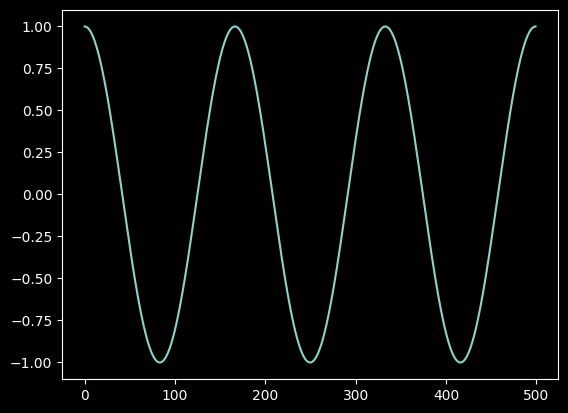

In [3]:
t = torch.linspace(0, 1, 500)
cos_wave = 1 * torch.cos(2 * torch.pi * 3 * t)

plt.plot(cos_wave.numpy())
plt.show()

In [4]:
inputs = cos_wave.reshape(-1, 1)
dataset = UniversalDataset(x=inputs, y=inputs)

In [11]:
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=CustomizedTemporal,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')


# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 16, "num_layers": 2, "bidirectional": False, "device": 'cpu'}

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=8,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          permute_dataset=False,
                          model_args=model_args) # pass the hyperparameters of your model


100%|██████████| 40/40 [00:05<00:00,  6.87it/s]



Final Training loss: 4.4575400379747435e-05
Final Validation loss: 0.00016739722923375666
Test MSE: 4.565785638988018e-05
Test MAE: 0.005181950516998768
Test RMSE: 0.006757059600204229


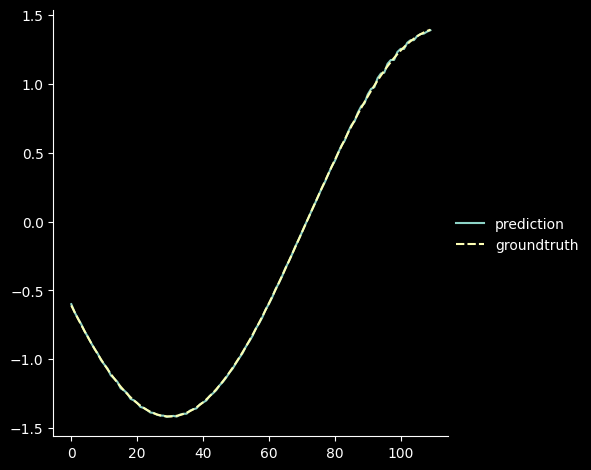

In [13]:
forecasts = task.plot_forecasts(task.test_dataset, index_range=[0,-1])

## Customized Spatial-Temporal Model

In [76]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse

from epilearn.models.SpatialTemporal.base import BaseModel

class CustomizedSpatialTemporal(BaseModel):
    def __init__(self,
                num_nodes,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                hidden_size,
                num_layers,
                bidirectional,
                device = 'cpu'):
        super(CustomizedSpatialTemporal, self).__init__(device=device)
        self.num_nodes = num_nodes
        self.num_feats = num_features
        self.hidden = hidden_size
        self.num_layers = num_layers
        self.bidirectional=bidirectional
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device

        self.gcn = GCNConv(in_channels=self.num_feats, out_channels=self.hidden)
        self.lstm = nn.LSTM(input_size=self.hidden, hidden_size=self.hidden, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(self.hidden, self.horizon)

    def forward(self, feature, graph, states=None, dynamic_graph=None, **kargs):
        # message passing to update node features
        edge_index, _ = dense_to_sparse(graph)

        x = self.gcn(feature.float(), edge_index=edge_index)

        x = x.transpose(1,2).reshape(-1, self.lookback, self.hidden)
        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch, seq_length, hidden_size * num_directions)
        # Decode the last hidden state
        out = out[:, -1, :]
        out = out.reshape(-1, self.num_nodes, self.hidden)
        out = self.fc(out).unsqueeze(-1)

        return out.transpose(1,2)

    def initialize(self):
        pass

In [73]:
# generate n cosines
num_nodes = 25
t = torch.linspace(0, 1, 500)
frequencies = torch.randint(low=1, high=10, size=[num_nodes])
cos_wave = 1 * torch.cos(2 * torch.pi * frequencies.unsqueeze(1) * t)

# generate random graph
graph = torch.round(torch.rand([num_nodes, num_nodes]))

In [74]:
inputs = cos_wave.unsqueeze(-1).transpose(0,1)
dataset = UniversalDataset(x=inputs, y=inputs, graph=graph)

In [77]:
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()],
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=CustomizedSpatialTemporal,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')
model_args = {"num_nodes": num_nodes, "num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 16, "num_layers": 2, "bidirectional": False, "device": 'cpu'}
# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=2,
                          batch_size=5,
                          train_rate=0.6,
                          val_rate=0.2,
                          permute_dataset=False,
                          model_args=model_args
                          )

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



Final Training loss: 0.9610863485426273
Final Validation loss: 0.907545804977417
Test MSE: 0.862384021282196
Test MAE: 0.8353271484375
Test RMSE: 0.9286463260650635


## Customized Spatial Model

In [99]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse

from epilearn.models.SpatialTemporal.base import BaseModel

class CustomizedSpatial(BaseModel):
    def __init__(self,
                num_nodes,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                hidden_size,
                device = 'cpu'):
        super(CustomizedSpatial, self).__init__(device=device)
        self.num_nodes = num_nodes
        self.num_feats = num_features
        self.hidden = hidden_size
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device

        self.gcn = GCNConv(in_channels=self.num_feats, out_channels=self.hidden)
        self.fc = nn.Linear(self.hidden, self.horizon)

    def forward(self, feature, graph, states=None, dynamic_graph=None, **kargs):
        x = feature.transpose(1,2).reshape(-1, self.num_nodes, self.num_feats)
        edge_index, _ = dense_to_sparse(graph)

        x = self.gcn(x, edge_index=edge_index)

        
        out = self.fc(x)

        return out

    def initialize(self):
        pass

In [92]:
graph = graph = torch.round(torch.rand([num_nodes, num_nodes])) # nodes, nodes
features = torch.round(torch.rand((10,num_nodes,1,1))) # batch, nodes, time steps, channels
node_target = torch.round(torch.rand((10,num_nodes))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([25, 25])
features: torch.Size([10, 25, 1, 1])
node_target: torch.Size([10, 25])


In [93]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [100]:
from epilearn.tasks.detection import Detection

lookback = 1 # inputs size
horizon = 2 # predicts size; also seen as number of classes

task = Detection(prototype=CustomizedSpatial, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

model_args = {"num_nodes": num_nodes, "num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 16, "device": 'cpu'}

result = task.train_model(dataset=dataset, 
                          loss='ce', 
                          epochs=25,
                          train_rate=0.6,
                          val_rate=0.1,
                          permute_dataset=False,
                          model_args=model_args
                          )

Model Initialized!


100%|██████████| 25/25 [00:00<00:00, 519.26it/s]



Final Training loss: 0.6910960674285889
Final Validation loss: 0.6977410316467285
Test ACC: 0.5066666603088379
